In [3]:
# Import necessary packages
from osgeo import gdal
import rasterio
from rasterio.transform import from_origin
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
import xarray as xr

In [4]:
# Path to the MODIS HDF file
hdf_file = 'raw-data/MODIS/MODIS_test_data.hdf'

# Open the HDF4 file using gdal
hdf_dataset = gdal.Open(hdf_file)

# List the available subdatasets
subdatasets = hdf_dataset.GetSubDatasets()

# Print the available subdatasets to find Band 31 emissivity
for i, sds in enumerate(subdatasets):
    print(f"Subdataset {i}: {sds[0]}")

/srv/conda/envs/notebook/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Subdataset 0: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_1KM_RefSB
Subdataset 1: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_1KM_RefSB_Uncert_Indexes
Subdataset 2: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_1KM_Emissive
Subdataset 3: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_1KM_Emissive_Uncert_Indexes
Subdataset 4: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_250_Aggr1km_RefSB
Subdataset 5: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_250_Aggr1km_RefSB_Uncert_Indexes
Subdataset 6: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_250_Aggr1km_RefSB_Samples_Used
Subdataset 7: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_500_Aggr1km_RefSB
Subdataset 8: HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MO

In [5]:
subdatasets[2][0]

'HDF4_EOS:EOS_SWATH:"raw-data/MODIS/MODIS_test_data.hdf":MODIS_SWATH_Type_L1B:EV_1KM_Emissive'

In [8]:
import rioxarray as rxr

hdf_dataset = rxr.open_rasterio(hdf_file, masked = True)
type(hdf_dataset)

list

In [9]:
hdf_dataset

[<xarray.Dataset> Size: 2GB
 Dimensions:                              (band: 16, y: 2030, x: 1354)
 Coordinates:
   * band                                 (band) int64 128B 1 2 3 4 ... 14 15 16
     spatial_ref                          int64 8B 0
 Dimensions without coordinates: y, x
 Data variables:
     EV_1KM_RefSB                         (band, y, x) float32 176MB nan ... nan
     EV_500_Aggr1km_RefSB_Samples_Used    (band, y, x) float32 176MB nan ... nan
     EV_Band26                            (band, y, x) float32 176MB 327.0 ......
     EV_Band26_Uncert_Indexes             (band, y, x) float32 176MB 15.0 ... nan
     EV_1KM_RefSB_Uncert_Indexes          (band, y, x) float32 176MB nan ... nan
     EV_1KM_Emissive                      (band, y, x) float32 176MB ...
     EV_1KM_Emissive_Uncert_Indexes       (band, y, x) float32 176MB ...
     EV_250_Aggr1km_RefSB                 (band, y, x) float32 176MB nan ... nan
     EV_250_Aggr1km_RefSB_Uncert_Indexes  (band, y, x) float32 1

In [4]:
# Indes subdatasets to extract EV_1KM_Emissive
data = gdal.Open(subdatasets[2][0])

# Get the metadata and geotransform
geotransform = data.GetGeoTransform()
projection = data.GetProjection()

# Read the data for Band 31
band_31_data = data.ReadAsArray()
band_31_data = band_31_data[10] #index 10 is Band 31, as the EV_1KM_Emissive is for bands 20-25 and 27-36.

In [46]:
# Define the output file path
output_tiff = "test_tiff_MODIS.tif"

# Write the data to GeoTIFF using rasterio
with rasterio.open(
    output_tiff,
    'w',
    driver='GTiff',
    height=band_31_data.shape[0],
    width=band_31_data.shape[1],
    count=1,
    dtype=band_31_data.dtype,
    crs=projection,
    transform=from_origin(geotransform[0], geotransform[3], geotransform[1], geotransform[5])
) as dst:
    dst.write(band_31_data, 1)

# Convert the GeoTIFF to Cloud Optimized GeoTIFF (COG)
cog_output = "test_cog_MODIS.tif"
cog_profile = cog_profiles.get("deflate")

cog_translate(
    output_tiff,
    cog_output,
    cog_profile,
    in_memory=False
)

print("COG creation complete.")

Reading input: test_tiff_MODIS.tif

Adding overviews...
Updating dataset tags...
Writing output to: test_cog_MODIS.tif


COG creation complete.


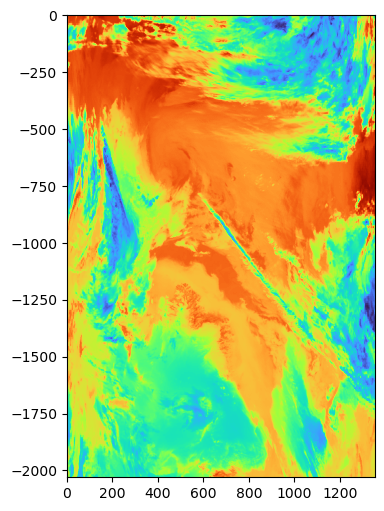

In [62]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

# Path to the Cloud Optimized GeoTIFF (COG)
cog_filename = "test_cog_MODIS.tif"

# Open the COG file using rasterio
with rasterio.open(cog_filename) as src:
    # Plot the COG file
    plt.figure(figsize=(10, 6))
    show(src, cmap='turbo')